In [1]:
import typing
import random
import torch
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import models, transforms
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from PIL import Image, ImageDraw
import json
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import math
import torch.nn.functional as F
import itertools
from datetime import datetime

In [2]:
#from google.colab import drive
import sys

BASE_PROJECT_PATH = 'PUT YOUR PROJECT PATH HERE'
#drive.mount('/content/drive')
sys.path.append(os.path.join(BASE_PROJECT_PATH, 'modules'))
from solarutils import *

Mounted at /content/drive


In [3]:
def finetune_bbox_model_twostage(model, train_dataloader, val_dataloader, device,
                             stage1_epochs, stage1_lr,
                             stage2_epochs, stage2_lr, momentum, weight_decay, verbose = False):
    """
    Fine-tunes bounding box model in two stages, with a validation loop.
    """
    model.to(device)

    # --- STAGE 1: Train only the RPN and RoI heads ---
    print("\n" + "="*50)
    print("--- Starting Stage 1: Training RPN and Heads ---")
    print("="*50)

    for param in model.backbone.parameters():
        param.requires_grad = False

    params_stage1 = [p for p in model.parameters() if p.requires_grad]
    optimizer_stage1 = torch.optim.SGD(params_stage1, lr=stage1_lr, momentum=momentum, weight_decay=weight_decay)

    for epoch in range(stage1_epochs):
        model.train()
        train_loss = 0
        if verbose:
            print(f"\nStage 1 - Epoch {epoch+1}/{stage1_epochs}")
            print('-' * 25)

        for i, (images, targets) in enumerate(train_dataloader):
            images = list(image.to(device) for image in images)
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
            loss_dict = model(images, targets)
            losses = sum(loss for loss in loss_dict.values())

            optimizer_stage1.zero_grad()
            losses.backward()
            optimizer_stage1.step()

            train_loss += losses.item()
            if verbose and (i + 1) % 10 == 0:
                print(f"  Batch {i+1}/{len(train_dataloader)}, Train Loss: {losses.item():.4f}")

        avg_train_loss = train_loss / len(train_dataloader)

        val_loss = calculate_val_loss_bbox(model, val_dataloader, device)
        avg_val_loss = val_loss / len(val_dataloader)
        print(f"Epoch {epoch+1} Summary -> Train Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}")

    # --- STAGE 2: Fine-tune all layers with a lower learning rate ---
    print("\n" + "="*50)
    print("--- Starting Stage 2: Fine-tuning all layers ---")
    print("="*50)

    for param in model.parameters():
        param.requires_grad = True

    optimizer_stage2 = torch.optim.SGD(model.parameters(), lr=stage2_lr, momentum=momentum, weight_decay=weight_decay)

    for epoch in range(stage2_epochs):
        model.train()
        train_loss = 0
        if verbose:
            print(f"\nStage 2 - Epoch {epoch+1}/{stage2_epochs}")
            print('-' * 25)

        for i, (images, targets) in enumerate(train_dataloader):
            images = list(image.to(device) for image in images)
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
            loss_dict = model(images, targets)
            losses = sum(loss for loss in loss_dict.values())

            optimizer_stage2.zero_grad()
            losses.backward()
            optimizer_stage2.step()

            train_loss += losses.item()
            if verbose and (i + 1) % 10 == 0:
                print(f"  Batch {i+1}/{len(train_dataloader)}, Train Loss: {losses.item():.4f}")

        avg_train_loss = train_loss / len(train_dataloader)

        val_loss = calculate_val_loss_bbox(model, val_dataloader, device)
        avg_val_loss = val_loss / len(val_dataloader)
        print(f"Epoch {epoch+1} Summary -> Train Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}")

    print("\nFine-tuning complete.")
    return model



Create model variations:

In [4]:
def generate_fasterrcnn_model_specs() -> typing.Dict[str, typing.Dict[str, typing.Union[int, float]]]:
    """
    Generate a dictionary of dictionaries, each containing a unique FasterRCNN model configuration and model hyperparameters
    by iterating over all possible combinations of the defined parameters.

    Returns:
        dict: Dictionary of model specifications keyed by model name.
    """
    model_specs: typing.Dict[str, typing.Dict[str, typing.Union[int, float]]] = {}

    # Define ranges for model hyperparameters
    learning_rate_choices: typing.List[float] = [0.001, 0.01]
    weight_decay_choices: typing.List[float] = [0.0001, 0.0005]
    num_epochs_choices: typing.List[int] = [5, 15]
    momentum_choices: typing.List[float] = [0.9, 0.95]
    batch_size_choices: typing.List[int] = [2, 4]

    # Iterate over all combinations of hyperparameters
    param_combinations = itertools.product(
        learning_rate_choices,
        weight_decay_choices,
        num_epochs_choices,
        momentum_choices,
        batch_size_choices
    )

    for i, params in enumerate(param_combinations):
        lr, weight_decay, num_epochs, momentum, batch_size = params

        spec: typing.Dict[str, typing.Union[int, float]] = {
            'lr': lr,
            'weight_decay': weight_decay,
            'num_epochs': num_epochs,
            'momentum': momentum,
            'batch_size': batch_size
        }
        model_specs[f"model_variant_{i+1}"] = spec

    return model_specs

In [5]:
def get_images_to_label_entropy_of_avg_score(all_model_prediction, k = 10, save_path_prefix = None):
    average_scores_list = []
    for img_name, scores in all_model_predictions.items():
        if scores:
            avg_score = np.mean(scores)
            average_scores_list.append({'file_name': img_name, 'score': avg_score})
    top_entropies = get_top_k_entropy_images(average_scores_list, k=len(average_scores_list))
    plot_and_save_top_entropies(top_entropies, save_path_prefix = save_path_prefix)
    return top_entropies[:k]

def get_images_to_label_avg_of_score_entropy(all_model_prediction, k = 10, save_path_prefix = None):
    score_entropies = {}
    for img_name, scores in all_model_predictions.items():
        if scores: score_entropies[img_name] = [calculate_binary_entropy(score) for score in scores]
    img_avg_entropies = sorted([(np.mean(entropies), img_name) for img_name, entropies in score_entropies.items()], key = lambda x: x[0], reverse=True)
    plot_and_save_top_entropies(img_avg_entropies, save_path_prefix = save_path_prefix)
    return img_avg_entropies[:k]


Train our models and produce predictions from all of them:

In [6]:
bbox_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

TIME = datetime.now().strftime("%Y_%m_%d_%H_%M")
BASE_PROJECT_PATH = '/content/drive/MyDrive/Erdos Institute - Solar Panels Project'
IMAGE_DIRECTORY = os.path.join(BASE_PROJECT_PATH, 'data', 'images') # Directory with images
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
NUM_CLASSES = 2
JSON_ANNOTATION_PATH = os.path.join(BASE_PROJECT_PATH, 'data', '2025_08_09_11_54_annotations.json') # Path to training annotations
AL_SAVE_PREFIX = os.path.join(BASE_PROJECT_PATH, 'active learning', f'{TIME}') # Prefix for saving active learning output

with open(JSON_ANNOTATION_PATH, 'r') as f:
  coco_data = json.load(f)
LABELED_FILENAME_SET = set([img['file_name'] for img in coco_data['images']])

VALIDATION_SPLIT = 0.1

# Generate model specifications
model_specs = generate_fasterrcnn_model_specs()

# Dictionary to store prediction scores for each model variant and image
all_model_predictions = {} # Key: image_id, Value: List of scores from every model for that image

# Data splitting and loading (done once for all models)
if not os.path.exists(JSON_ANNOTATION_PATH) or not os.path.exists(IMAGE_DIRECTORY):
  print(f"Error: Ensure annotation file and image directory exist.")
  raise FileNotFoundError

# --- Data Loading and Splitting ---
full_dataset = BoundingboxDataset(
    JSON_ANNOTATION_PATH,
    IMAGE_DIRECTORY,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])) # Use ImageNet values for normalization
for model_name, specs in model_specs.items():
    print(f"\n--- Processing {model_name} ---")

    # Get a new model instance for each variant
    model = get_bbox_detection_model(NUM_CLASSES)

    train_dataloader, val_dataloader = dataset_split(full_dataset,
                              [specs['batch_size'], specs['batch_size']],
                              1-VALIDATION_SPLIT, seed = random.randint(1,1000))

    # Train the model variant
    trained_model = finetune_bbox_model_twostage(model, train_dataloader, val_dataloader, DEVICE,
                    stage1_epochs=int(specs['num_epochs'] * 0.6), stage1_lr=specs['lr'],
                    stage2_epochs=specs['num_epochs'] - int(specs['num_epochs'] * 0.6), stage2_lr=specs['lr']*0.1,
                    momentum=specs['momentum'], weight_decay=specs['weight_decay'])

    del train_dataloader, val_dataloader
    # Use it on unlabeled images
    coco_predictions_output = run_bbox_model(
        trained_model,
        bbox_transform,
        IMAGE_DIRECTORY,
        DEVICE,
        banned_subset = LABELED_FILENAME_SET,
        threshold = 0
    )

    # Collect scores
    img_id_2_filename = {}
    for image in coco_predictions_output['images']:
        img_id_2_filename[image['id']] = image['file_name']
    for annotation in coco_predictions_output.get('annotations', []):
        img_name = img_id_2_filename[annotation.get('image_id')]
        score = annotation.get('score')

        if img_name is not None and score is not None:
            if img_name not in all_model_predictions:
                all_model_predictions[img_name] = []
            all_model_predictions[img_name].append(score)
    del model, trained_model, coco_predictions_output


--- Processing model_variant_1 ---


Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_v2_coco-dd69338a.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_v2_coco-dd69338a.pth
100%|██████████| 167M/167M [00:00<00:00, 235MB/s]


Training set size: 540
Validation set size: 61

--- Starting Stage 1: Training RPN and Heads ---
Epoch 1 Summary -> Train Loss: 0.2132, Validation Loss: 0.1677
Epoch 2 Summary -> Train Loss: 0.1616, Validation Loss: 0.1298
Epoch 3 Summary -> Train Loss: 0.1379, Validation Loss: 0.1193

--- Starting Stage 2: Fine-tuning all layers ---
Epoch 1 Summary -> Train Loss: 0.1266, Validation Loss: 0.1161
Epoch 2 Summary -> Train Loss: 0.1230, Validation Loss: 0.1106

Fine-tuning complete.

--- Running bounding box model ---

--- Processing model_variant_2 ---
Training set size: 540
Validation set size: 61

--- Starting Stage 1: Training RPN and Heads ---
Epoch 1 Summary -> Train Loss: 0.2294, Validation Loss: 0.1829
Epoch 2 Summary -> Train Loss: 0.1805, Validation Loss: 0.1623
Epoch 3 Summary -> Train Loss: 0.1644, Validation Loss: 0.1438

--- Starting Stage 2: Fine-tuning all layers ---
Epoch 1 Summary -> Train Loss: 0.1503, Validation Loss: 0.1447
Epoch 2 Summary -> Train Loss: 0.1479, Valid

Plot saved to: /content/drive/MyDrive/Erdos Institute - Solar Panels Project/active learning/2025_08_09_19_23entropy_avg_entropies.png
Entropies data saved to: /content/drive/MyDrive/Erdos Institute - Solar Panels Project/active learning/2025_08_09_19_23entropy_avg_entropies.csv


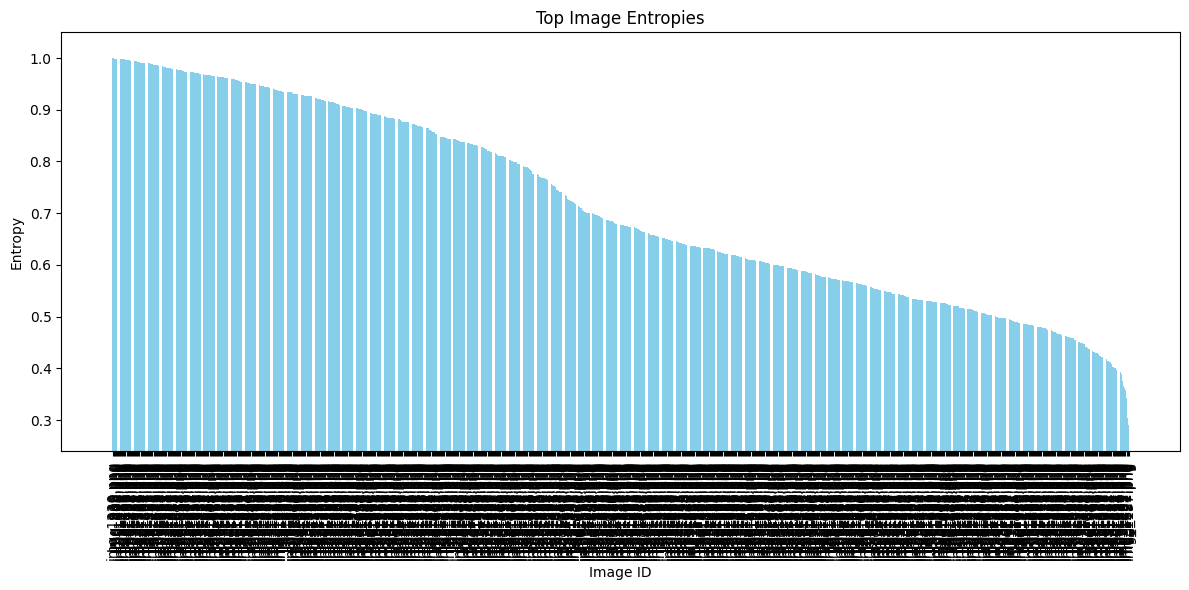

[(np.float64(0.9996663972166658), 'img_1220.png'),
 (np.float64(0.9992826495363941), 'img_910.png'),
 (np.float64(0.9990644420535215), 'img_903.png'),
 (np.float64(0.9990461188048616), 'img_528.png'),
 (np.float64(0.9990003057279015), 'img_602.png'),
 (np.float64(0.9989684975188391), 'img_700.png'),
 (np.float64(0.9987864671580426), 'img_424.png'),
 (np.float64(0.9987842950511542), 'img_1025.png'),
 (np.float64(0.9987836634132505), 'img_1130.png'),
 (np.float64(0.9985810304325113), 'img_758.png')]

In [7]:
get_images_to_label_entropy_of_avg_score(all_model_predictions, k = 10, save_path_prefix = AL_SAVE_PREFIX+"entropy_avg")

Plot saved to: /content/drive/MyDrive/Erdos Institute - Solar Panels Project/active learning/2025_08_09_19_23avg_entropy_entropies.png
Entropies data saved to: /content/drive/MyDrive/Erdos Institute - Solar Panels Project/active learning/2025_08_09_19_23avg_entropy_entropies.csv


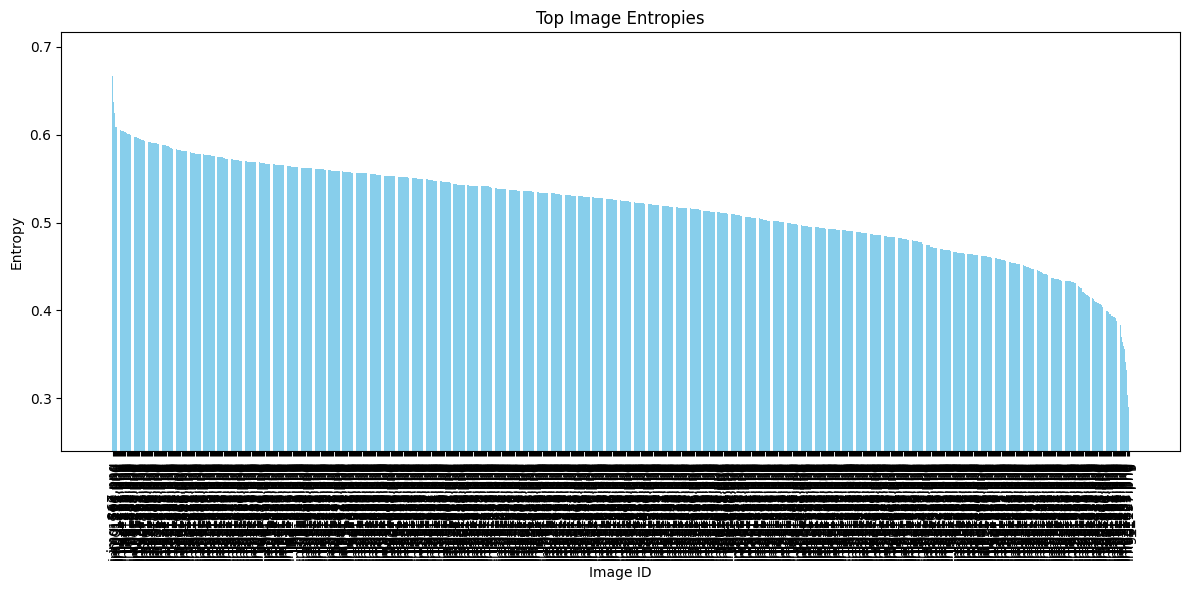

[(np.float64(0.6662927526902529), 'img_867.png'),
 (np.float64(0.6365579904050316), 'img_739.png'),
 (np.float64(0.6249515751571733), 'img_1504.png'),
 (np.float64(0.6091498557486474), 'img_996.png'),
 (np.float64(0.6085192804697837), 'img_1455.png'),
 (np.float64(0.6078736516921204), 'img_1225.png'),
 (np.float64(0.6070941918949918), 'img_1151.png'),
 (np.float64(0.6050839431399299), 'img_1474.png'),
 (np.float64(0.6046022931102861), 'img_1316.png'),
 (np.float64(0.6044547171115001), 'img_795.png')]

In [8]:
get_images_to_label_avg_of_score_entropy(all_model_predictions, k = 10, save_path_prefix = AL_SAVE_PREFIX+"avg_entropy")